# Emotion-Recognition CK+ Model V1

## Intro

First of all we need a proper dataset containing thousands of facial expression images. For this I will be using two different datsets, the first one from CK+ and the second from Kaggle.
On this notebook I will use the CK+ dataset, the problem is that it contains less images than the Kaggle one, so because of the lack of data we will probably have overfitting problems.

## Hardware Information and GPU Support

Let's start by checking if Tesorflow is correctly detecting and using the GPU.

In [1]:
# Imports
import psutil as ps
import GPUtil as gpx
import platform
from tabulate import tabulate
from datetime import datetime
import seedir as sd
import matplotlib.pyplot as plt
import plotly.graph_objects as pgo
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dense, Input, Dropout,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
from keras.models import model_from_yaml
%matplotlib inline

# Simple helper function to scale to higher values
def get_size(bytes, suffix="B"):
    """
    Scale bytes to its proper format
    e.g:
        1253656 => '1.20MB'
        1253656678 => '1.17GB'
    """
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor


# First let's define a function to display the system's information
def print_system_info():
    # System Info
    print("="*20, "System Information", "="*20)
    uname = platform.uname()
    print(f"System: {uname.system}")
    print(f"Release: {uname.release}")
    print(f"Processor: {uname.machine}")

    print("\n")

    # CPU Info
    # let's print CPU information
    print("="*25, "CPU Info", "="*25)
    # number of cores
    print("Physical cores:", ps.cpu_count(logical=False))
    print("Total cores:", ps.cpu_count(logical=True))
    # CPU frequencies
    cpufreq = ps.cpu_freq()
    print(f"Current Frequency: {cpufreq.current:.2f}Mhz")

    print("\n")

    # Memory Information
    print("="*20, "Memory Information", "="*20)
    # get the memory details
    svmem = ps.virtual_memory()
    print(f"Total: {get_size(svmem.total)}")
    print(f"Available: {get_size(svmem.available)}")
    print(f"Used: {get_size(svmem.used)}")
    print(f"Percentage: {svmem.percent}%")
    
    print("\n")
    
    # Swap Information
    print("="*27, "SWAP", "="*27)
    swap = ps.swap_memory()
    print(f"Total: {get_size(swap.total)}")
    print(f"Free: {get_size(swap.free)}")
    print(f"Used: {get_size(swap.used)}")
    print(f"Percentage: {swap.percent}%")

    print("\n")

    # Disk Information
    print("="*21, "Disk Information", "="*21)
    print("Partitions and Usage:")
    partitions = ps.disk_partitions()
    # I want only to get the information about the main SSD where Windows is installed
    print(f"=== Device: {partitions[0].device} ===")
    print(f"  Mountpoint: {partitions[0].mountpoint}")
    print(f"  File system type: {partitions[0].fstype}")
    partition_usage = ps.disk_usage(partitions[0].mountpoint)
    print(f"  Total Size: {get_size(partition_usage.total)}")
    print(f"  Used: {get_size(partition_usage.used)}")
    print(f"  Free: {get_size(partition_usage.free)}")
    print(f"  Percentage: {partition_usage.percent}%")

    print("\n")

    # GPU Information
    print("="*24, "GPU Details", "="*24)
    gpus = gpx.getGPUs()
    list_gpus = []
    for gpu in gpus:
        # name of GPU
        gpu_name = gpu.name
        # get % percentage of GPU usage of that GPU
        gpu_load = f"{gpu.load*100}%"

        gpu_free_memory = f"{round(gpu.memoryFree/1024,2)}GB"
        gpu_used_memory = f"{round(gpu.memoryUsed/1024,2)}GB"
        gpu_total_memory = f"{round(gpu.memoryTotal/1024,2)}GB"
        gpu_temperature = f"{gpu.temperature} °C"
        list_gpus.append((
            gpu_name, gpu_free_memory, gpu_used_memory,
            gpu_total_memory, gpu_temperature
        ))
    print(tabulate(list_gpus, headers=("Name", "Free VRAM", "Used VRAM", "Total VRAM", "Temperature")))
    print("\n")



# Function top check if tensorflow is installed and if it is detecting the GPU correctly
def tensorflow_gpu_check():
    print("="*24, "Tensorflow", "="*24)
    print("Version: ", tf.__version__)
    print("GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


print_system_info()
tensorflow_gpu_check()

==================== System Information ====================
System: Windows
Release: 10
Processor: AMD64


========================= CPU Info =========================
Physical cores: 16
Total cores: 32
Current Frequency: 3401.00Mhz


==================== Memory Information ====================
Total: 63.95GB
Available: 56.05GB
Used: 7.89GB
Percentage: 12.3%


=========================== SWAP ===========================
Total: 76.36GB
Free: 56.58GB
Used: 19.78GB
Percentage: 25.9%


===================== Disk Information =====================
Partitions and Usage:
=== Device: C:\ ===
  Mountpoint: C:\
  File system type: NTFS
  Total Size: 1.82TB
  Used: 236.26GB
  Free: 1.59TB
  Percentage: 12.7%


======================== GPU Details ========================
Name                     Free VRAM    Used VRAM    Total VRAM    Temperature
-----------------------  -----------  -----------  ------------  -------------
NVIDIA GeForce RTX 3090  23.22GB      0.78GB       24.0GB        37.0 °C


## Dataset
Now that we checked that Tensorflow is correctly installed and detecting the GPU, let's get a better understanding of the dataset that we will be using.

The first dataset we are using is the Extended Cohn-Kanade (CK+), which contains 327 images divided in 7 categories (emotions):
- Anger
- Contempt
- Disgust
- Fear
- Happiness
- Sadness
- Surprise

In [2]:
print("Dataset Classes Distribution")

# Path to dataset
dataset_path = '../../../datasets/CKplus_dataset/'

# Let's display and count the files in the Kaggle training dataset
sd.seedir(dataset_path, style='emoji', itemlimit=10, depthlimit=1, beyond='content')

# Find number of images for each class
classes = []
values = []
for emotion in os.listdir(dataset_path):
    classes.append(emotion)
    values.append(len(os.listdir(dataset_path+emotion)))

# Chart visualization of the classes
fig = pgo.Figure(data=[pgo.Pie(labels=classes, values=values, hole=.4)])
fig.show()


Dataset Classes Distribution
📁 /
├─📁 anger/
│ └─0 folder(s), 45 file(s)
├─📁 contempt/
│ └─0 folder(s), 18 file(s)
├─📁 disgust/
│ └─0 folder(s), 59 file(s)
├─📁 fear/
│ └─0 folder(s), 25 file(s)
├─📁 happiness/
│ └─0 folder(s), 69 file(s)
├─📁 sadness/
│ └─0 folder(s), 28 file(s)
└─📁 surprise/
  └─0 folder(s), 83 file(s)


 The folders don't contain the same amount of images for each emotion, for example we have 83 images containing a surprised face and only 18 images containing contempt. Hence we have some degree of imbalance, so we have to take in account this problem and solve it by using data augmentation method (ImageDataGenerator will come in handy for augmentation).

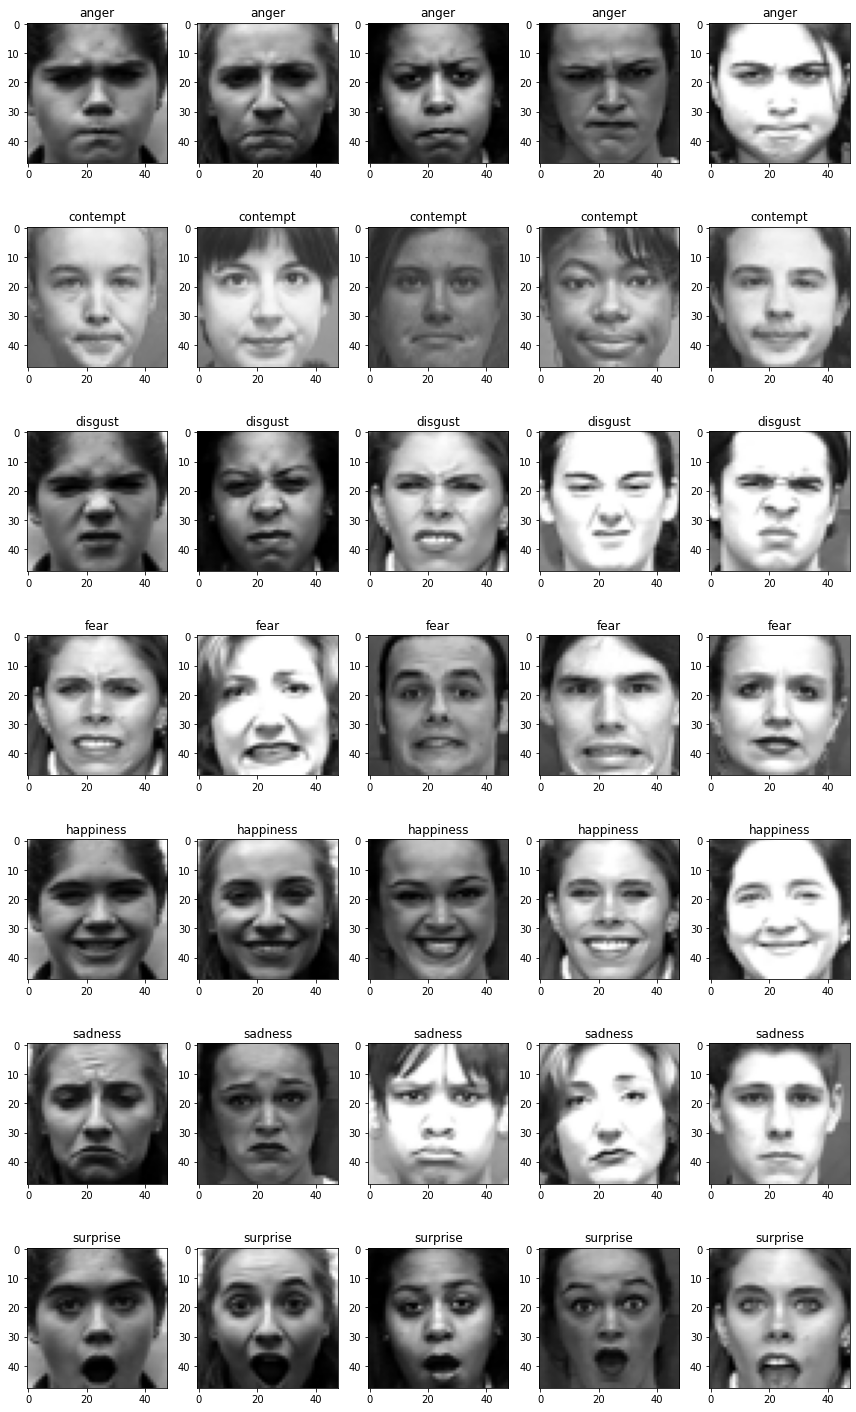

In [3]:
def plot_dataset_images(plt,img_size,dir):
    img_size = img_size
    plt.figure(0, figsize=(12,20))
    index = 0

    for emotion in os.listdir(dir):
        for i in range(1,6):
            index += 1
            plt.subplot(7,5,index)
            img = load_img(dir + emotion + "/" +os.listdir(dir + emotion)[i], target_size=(img_size, img_size))
            plt.imshow(img, cmap="gray")
            plt.title(f"{emotion}")

    plt.tight_layout()
    return plt

plot_dataset_images(plt,48,dataset_path).show()

As we can see the dataset is composed of 48 by 48 pixel images in grayscale mode. We should divide the whole datset in two different folders:
- training_dataset/
- testing_dataset/

We do this in order to have one set for training the neural network and one set containing images that the model has never seen, so we can test how accurate it is. The idea is to have 20% of the whole dataset reserved for testing and the remaining 80% for training.

## Racial Discrimination

The images in the CK+ dataset are composed by taking pictures of 210 adults having an age span between 18 to 50 years old. Furthermore the ethnicity is as follows:
- 81% Euro-American
- 13% Afro-American
- 6% Other ethnic groups

This creates a racial discrimination problem since our model will mainly train having a strong "Euro-American" dataset oriented. This is very important aspect to keep in mind in case we have to deploy the model in real-life applications.

## Data Augmentation

Deep learning models normally need a big datset in order to be properly trained, but since our CK+ dataset is not that large, we will be using data augmentation techniques in order to increase the amount of "data" by performing random transformations on the images contained in the original dataset and returning it for the training.

In this case we are using ImageDataGenerator from TensorFlow-Keras, which generates batches of tensor image data with real-time or so called in-place data augmentation. Here is how ImageDataGenerator generally works:

1. It accepts a batch of images used for training;
2. It then applies a series of random transformations to each image in the batch (for example random rotation, resizing, shearing, etc.);
3. It then replaces the original batch with the new created one;
4. Then we train the CNN on this randomly transformed batch.

In [4]:
# First the only data augmentation will be the horizontal flip, for further models I will add more complex transformation
training_datagen = ImageDataGenerator(horizontal_flip=True)
training_generator = training_datagen.flow_from_directory(
        '../../../datasets/CKplus_training_dataset/',
        target_size=(48, 48),
        batch_size=32,
        class_mode="categorical",
        color_mode="grayscale",
        shuffle=True,
        )

validation_datagen = ImageDataGenerator(horizontal_flip=True)
validation_generator = validation_datagen.flow_from_directory(
        '../../../datasets/CKplus_testing_dataset/',
        target_size=(48, 48),
        batch_size=32,
        class_mode="categorical",
        color_mode="grayscale",
        shuffle=True,
        )

Found 265 images belonging to 7 classes.
Found 62 images belonging to 7 classes.


## Neural Network Model

One important aspect for the project to work as expected is to choose the right neural network model.

For getting started we will use a not so complex CNN and maybe later experiment with other types of models.

In [5]:
# Initialising the CNN
model = Sequential()

# Convolutional Layer N.1
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Convolutional Layer N.2
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Convolutional Layer N.3
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Convolutional Layer N.4
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Now we flatten the volume to pass it to the fully connected layers
model.add(Flatten())

# Now we create the first fully connected layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))

# Now we create the second fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))

# Now we create the output [7 is the number of classes]
# We use softmax since it's for multi-classification
model.add(Dense(7, activation="softmax"))

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

## Training

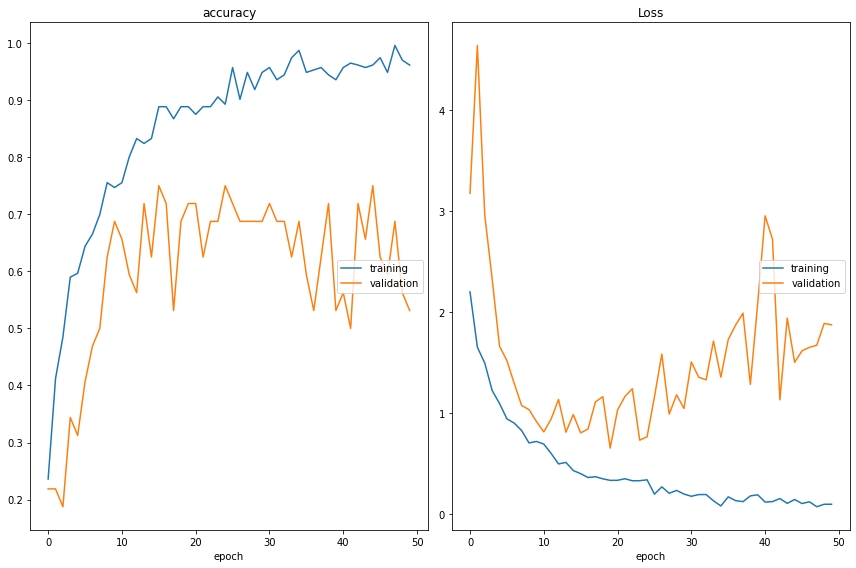

accuracy
	training         	 (min:    0.236, max:    0.996, cur:    0.961)
	validation       	 (min:    0.188, max:    0.750, cur:    0.531)
Loss
	training         	 (min:    0.069, max:    2.197, cur:    0.094)
	validation       	 (min:    0.650, max:    4.637, cur:    1.871)


In [6]:
# Set epochs and validation steps and steps per epoch
epochs = 50
steps_per_epoch = training_generator.n//training_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Optimizer [tweak for how much time training will take]
model.compile(optimizer=Adam(lr=0.0005), loss="categorical_crossentropy", metrics=["accuracy"])
callbacks = [PlotLossesKerasTF()]

# Train the model
history = model.fit(
    x=training_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

### Reuslts

The results are not tha bad, we got a 96% accuracy on the training set and a final 53% accuracy on the validation set, but the max was 75% accuracy on validation. The validation accuracy dropped after epoch 20, so I will create a v2 model with only 20 epochs and see which values we get. Maybe reducing complexity will help out, so on v3 I will instead remove some layers from the model.

The model has overfitting problems. We will see how the model performs in real-life application.

### Save the model

In [8]:
model.save("ck_model_gen1.h5")

# serialize the model to json
model_json = model.to_json()
# save the model architecture to JSON file
with open("ck_model_gen1.json", "w") as json_file:
    json_file.write(model_json)

model_yaml = model.to_yaml()
with open("ck_model_gen1.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

In [1]:
# Convert model to TensorFlowJS
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model,'tensorflowJS')